<a href="https://colab.research.google.com/github/pachterlab/Bi-BE-CS-183-2022/blob/main/HW9/Problem3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bi/Be/Cs 183 2021-2022: Intro to Computational Biology
TAs: Meichen Fang, Tara Chari, Zitong (Jerry) Wang

**Submit your notebooks by sharing a clickable link with Viewer access. Link must be accessible from submitted assignment document.**

Make sure Runtime $\rightarrow$ Restart and run all works without error

**HW 9 Problem 3**

In this question, you will implement Gillepie's stochastic simulation algorithm and use it to examine the approximate solutions you worked out in Problems 1 and 2.


In [ ]:
import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
%config InlineBackend.figure_format = 'retina'

#Core simulation code: Gillespie algorithm

This is the core of the simulation code, a vectorized version of the procedure described in [Gillespie (1976)](https://www.sciencedirect.com/science/article/pii/0021999176900413). You do not need to make any changes to this, but you should be aware of the following conventions for inputs and outputs:

`k`: vector of reaction rates.

`tvec`: strictly increasing vector of observation times, length $n$.

`S`: stochichiometry matrix, size $n_r \times n_s$, where $n_r$ is the number of reactions and $n_s$ is the number of species. Tracks the changes in species amounts due to each reaction.

`nCells`: integer number of cells to simulate.

`propfun`: a function that defines the _propensities_ of reactions enumerated in `S`. As described in lecture, the propensities are instantaneous rates that govern the reaction waiting times.

In [ ]:
def gillvec(k,tvec,S,nCells,propfun):
    n_species = S.shape[1]

    num_t_pts = len(tvec)
    X_mesh = np.zeros((nCells,num_t_pts,n_species),dtype=int) #change to float if storing floats!!!!!!! 

    t = np.zeros(nCells,dtype=float)
    tindex = np.zeros(nCells,dtype=int)

    #initialize state: integer unspliced, integer spliced 
    X = np.zeros((nCells,n_species),dtype=int)

	#initialize list of cells that are being simulated
    activecells = np.ones(nCells,dtype=bool)
    while any(activecells):
        mu = np.zeros(nCells,dtype=int)
        n_active_cells = np.sum(activecells)		
        (dt,mu_upd) = rxn_calculator(X[activecells,:],k,propfun)

        t[activecells] += dt
        mu[activecells] = mu_upd

        update = np.zeros(nCells,dtype=bool)
        update[activecells] = t[activecells] > tvec[tindex[activecells]]
        while np.any(update):
            X_mesh[update,tindex[update],:] = X[update]
            tindex += update
            ended_in_update = (tindex==num_t_pts) #less efficient
            if np.any(ended_in_update):
                activecells[ended_in_update] = False
                mu[ended_in_update] = 0
                if not np.any(activecells):
                    print('end simulation')
                    break
            update = np.zeros(nCells,dtype=bool)
            update[activecells] = t[activecells]>tvec[tindex[activecells]]
        # not_burst = mu > 1
        # burst = mu == 1

        X[activecells] += S[mu[activecells]-1]
		# if np.any(burst):		
		# 	bs_rxn = np.random.geometric(1/(1+bs),size=sum(burst))-1	
		# 	addn = np.zeros((sum(burst),n_species),dtype='int')	 
		# 	addn[:,0] = bs_rxn
		# 	X[burst] += addn
    return X_mesh

def rxn_calculator(X,k,propfun):
	nRxn = len(k)
	nCells = X.shape[0]

	a = np.zeros((nCells,nRxn),dtype=float)
 ################################
	a = propfun(a, k, X)
#################################
	a0 = np.sum(a,1)
	dt = np.log(1./np.random.rand(nCells)) / a0
	r2ao = a0 * np.random.rand(nCells)
	mu = np.sum(np.matlib.repmat(r2ao,nRxn+1,1).T >= np.cumsum(np.matlib.hstack((np.zeros((nCells,1)),a)),1) ,1)
	# print(mu)
	return (dt,mu)


# Problem 3
In this question, we will compare our results to stochastic simulations and see how well the various approximations work. The core of the simulation code is already implemented. It remains for you to write the $\textit{propensity functions}$ that determine the instantaneous rates of the reactions. This amounts to writing down the individual contributions to the efflux rates in the matrix $\mathcal{A}$. 

For example, consider the constitutive production system with transcription rate $k_A$, degradation rate $\gamma$, and $n$ molecules of RNA. At each instant, it will assign a propensity of $k$ to the transcription reaction and $\gamma n$ to the degradation reaction. 

Below is an example of how to do the stochastic simulations.




## Example: Constitutive production of two independent genes

You will need to write down `propfun` functions, which take in a `k` array, defining the parameters, and an `x` array, defining the current state.

As an example, you could imagine simulating a system with two independent constitutively produced RNA species with transcription rates $k_{1}, k_{2}$ and degradation rates $\gamma_1, \gamma_2$:
$$
\varnothing \xrightarrow{k_1} \mathcal{T}_1 \xrightarrow{\gamma_1} \varnothing\\
\varnothing \xrightarrow{k_2} \mathcal{T}_2 \xrightarrow{\gamma_2} \varnothing
$$
Then `x[0]` will give the copy number of the first mRNA and `x[1]` will report the copy number of the second RNA. The `k` array will be `[k1, k2, g1, g2]`. There are two species and four reactions. We can list them out in order (birth of RNA 1, death of RNA 1, birth of RNA 2, death of RNA 2), along with their effects on the RNA numbers.

The stoichiometry matrix will take the following form:
$$\begin{bmatrix} 1 & 0 \\ -1 & 0 \\ 0 & 1 \\ 0 & -1\end{bmatrix}$$

As expected, the birth (transcription) reactions add 1 to the count of the corresponding RNA; the death reactions subtract 1 from the count.

The propensity function will take the following form:

```
def propfun_indep(a,k,x):
    k1, k2, g1, g2 = k
    ...
    #######
    #fill in this part
    a[0] = k1
    a[1] = g1 * x[0]
    a[2] = k2 
    a[3] = g2 * x[1]
    #######
    ...
    return a
```



Let's try this worked example. First, fill in the propensities, so that the rate of each reaction is correctly described by the amounts of the reactants.

In [ ]:
S = np.array([[1,0],[-1,0],[0,1],[0,-1]])
def propfun_indep(a,k,x):
    k1, k2, g1, g2 = k
    x = x.T
    a = a.T
    #######
    #fill in this part
    a[0] = k1
    a[1] = g1 * x[0]
    a[2] = k2 
    a[3] = g2 * x[1]
    #######
    a = a.T
    return a

Initialize the parameter values. (Please do not change these).

In [ ]:
T = 5
k = [1,2, 0.75,0.15]
k1, k2, g1, g2 = k
measure_time = T/min(k)

Simulate a single trajectory to equilibrium.

end simulation


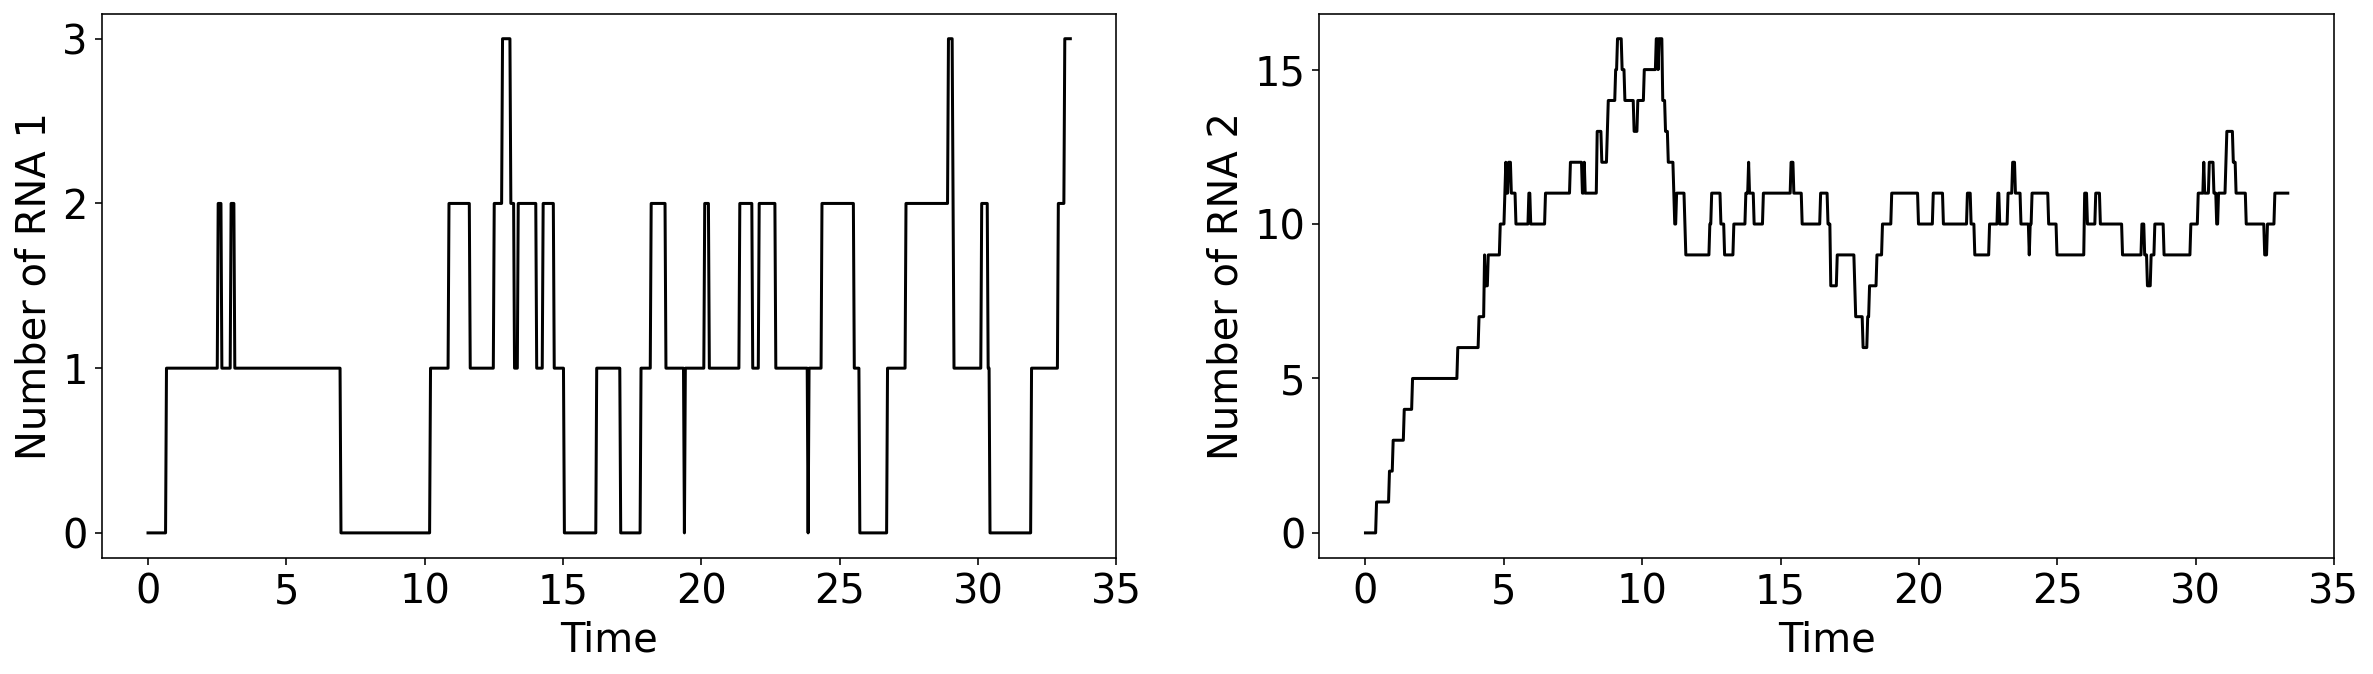

In [ ]:
fs = 20
tvec = np.linspace(0,measure_time,1000,endpoint=True)
nCells = 1
X=gillvec(k,tvec,S,nCells,propfun_indep) 

fig1,ax1=plt.subplots(nrows=1,ncols=2,figsize=(20,5))

ax1[0].plot(tvec,X[0,:,0],alpha=1,color='k')
ax1[0].set_xlabel('Time',fontsize=fs)
ax1[0].set_ylabel('Number of RNA 1',fontsize=fs)
ax1[0].tick_params(axis='y',labelsize=fs)
ax1[0].tick_params(axis='x',labelsize=fs)

ax1[1].plot(tvec,X[0,:,1],alpha=1,color='k')
ax1[1].set_xlabel('Time',fontsize=fs)
ax1[1].set_ylabel('Number of RNA 2',fontsize=fs)
ax1[1].tick_params(axis='x',labelsize=fs)
ax1[1].tick_params(axis='y',labelsize=fs)

We will begin with the bursty regime of the telegraph model of transcription.

## Part I telegraph model of transcription

Using the above example as a template, we would like to simulate a more complex process with a regulated gene locus:

\begin{split}
I &\xrightarrow{k_{on}} A\\
A &\xrightarrow{k_{off}} I\\
A &\xrightarrow{k_A} A + \mathcal{T}\\
\mathcal{T} &\xrightarrow{\gamma} \varnothing
\end{split}

Write down the stoichiometry matrix for the gene locus/RNA system.

In [ ]:
S = np.array([[1,0],[-1,0],[0,1],[0,-1]])

Make sure to get an intuition for this. There are four reactions: gene activation, gene inhibition, RNA production from an activated gene, RNA degradation. There are two "species" affected by the reactions: the gene state, which only takes on values in $\{0,1\}$, and the number of RNA, which can be any integer in $\mathbb{N}_0$. 

Now, write down the propensity functions corresponding to these four reactions. The input to the function `propfun` will include `k`, defined as the vector of $k_{on}, k_{off}, k_A, \gamma$ (named in more descriptive terms in the first line of the code proper). 

You need to define each entry of the vector `a` as a function of the parameter values and the entries of `x`. The entries of `a` are propensities of the four reactions. The entries of `x` are the species (gene state and mRNA count).

### (a) Use the code layout provided to make a function that calculates reaction rates for the telegraph model, as outlined in Equations 1 and 3. (5 pts)
The parameters are $k_{on}$, $k_{off}$, $k_{A}$, and $\gamma$. The inputs are $X$, the current state of the random telegraph process (inactive if zero, active if one), and $N$, the number of RNA molecules. The outputs are the propensities of the following reactions: activation, deactivation, transcription from active state, degradation.

In [ ]:
def propfun_gene(a,k,x):
    kon, koff, ktransc, kdeg = k
    x = x.T
    a = a.T
    #######
    #fill in this part
    
    #######
    a = a.T

    return a

### b) Simulate the process and compare your solution to the pre-defined negative binomial approximation. (5 pts)

We can use the same template code to study a coupled transcriptional-translational system, which is not tractable analytically. We wish to compare our microscopic, mesoscopic, and macroscopic approximations to the true protein distributions under the assumption of large timescale separation but moderate protein numbers.


In [ ]:
T = 5
k = [0.5,12, 26,2]
kon, koff, ktransc, kdeg = k
measure_time = T/min(k)

## Part 2 telegraph model with constitutive transcription and translation

### c) Use the code layout provided to make a function that calculates reaction propensities for the model with constitutive transcription and translation (5 pts)
The parameters are $k$, $\gamma$, $k_t$, and $\gamma_p$. The inputs are $N$, the current number of RNA molecules and $P$, the current number of protein molecules. The outputs are the propensities of the following reactions: RNA transcription, RNA degradation, protein translation, protein degradation.
\begin{align}
        \varnothing &\xrightarrow{k} \mathcal{T}\\
        \mathcal{T} &\xrightarrow{\gamma} \varnothing\\
        \mathcal{T} &\xrightarrow{k_t} \mathcal{T} + \mathcal{P}\\
        \mathcal{P} &\xrightarrow{\gamma_p} \varnothing,
\end{align} 

In [ ]:
S = np.array([[1,0],[-1,0],[0,1],[0,-1]])

Write down the propensity function for the protein/RNA system.

In [ ]:
def propfun_transl(a,k,x):
    ktx,kdeg,ktransl,kpdeg = k
    x = x.T
    a = a.T
    #######
    #fill in this part
    
    #######
    a = a.T

    return a

### d) Simulate the process and compare your solution to the three approximations obtained in 2a, 2b, and 2f. (5 pts)
Simulate the system. Note that this will take a while if the system is very stiff.

In [ ]:
T = 5
# k = [4.1,1.9, 0.15,0.01]
k = [4.1,1.9, 0.09,0.01]
ktx,kdeg,ktransl,kpdeg = k
measure_time = T/min(k)